<a href="https://colab.research.google.com/github/ElizavetaNosova/DeepNLP-HSE-homeworks/blob/main/Deep_learning_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving data.py to data (1).py


{'data.py': b"import os\r\nimport time\r\nimport requests\r\nimport shutil\r\nimport gzip\r\n\r\nfrom typing import Dict, List, Tuple\r\n\r\nfrom tqdm import tqdm\r\n\r\nimport pandas as pd\r\nfrom sklearn.model_selection import train_test_split\r\n\r\n\r\nclass Downloader:\r\n\r\n    URLS = {\r\n        'single': [\r\n            'http://jmcauley.ucsd.edu/data/amazon/qa/qa_Appliances.json.gz',\r\n            'http://jmcauley.ucsd.edu/data/amazon/qa/qa_Arts_Crafts_and_Sewing.json.gz',\r\n            'http://jmcauley.ucsd.edu/data/amazon/qa/qa_Automotive.json.gz',\r\n            'http://jmcauley.ucsd.edu/data/amazon/qa/qa_Baby.json.gz',\r\n            'http://jmcauley.ucsd.edu/data/amazon/qa/qa_Beauty.json.gz',\r\n            'http://jmcauley.ucsd.edu/data/amazon/qa/qa_Cell_Phones_and_Accessories.json.gz',\r\n            'http://jmcauley.ucsd.edu/data/amazon/qa/qa_Clothing_Shoes_and_Jewelry.json.gz',\r\n            'http://jmcauley.ucsd.edu/data/amazon/qa/qa_Electronics.json.gz',\r\n   

In [4]:
import math
import numpy as np

from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from nltk.tokenize import word_tokenize, wordpunct_tokenize

import zipfile

import seaborn as sns

from data import Downloader, Parser

In [5]:
# раскомментируйте и скачайте
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2021-04-04 10:43:16--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip.5’

wiki-news-300d-1M.v 100%[===================>] 650.22M  31.0MB/s    in 21s     

2021-04-04 10:43:38 (30.4 MB/s) - ‘wiki-news-300d-1M.vec.zip.5’ saved [681808098/681808098]



In [6]:
# путь к данным
data_path = './data/'

In [7]:
downloader = Downloader(data_path=data_path)
downloader.run()
parser = Parser(data_path=data_path)
unlabeled, train, valid = parser.run()

Reading: 100%|██████████| 38/38 [02:23<00:00,  3.78s/it]


In [11]:
# проверим, что в трейне и валидации одинаковые категории
set(train.category.unique().tolist()) == set(valid.category.unique().tolist())

True

In [8]:
unique_categories = set(train.category.unique().tolist() + valid.category.unique().tolist())
category2index = {category: index for index, category in enumerate(unique_categories)}
category2index

{'automotive': 6,
 'baby': 0,
 'beauty': 4,
 'cell phones and accessories': 3,
 'grocery and gourmet food': 1,
 'office products': 2,
 'pet supplies': 5,
 'sports and outdoors': 7}

In [9]:
train['target'] = train.category.map(category2index)
valid['target'] = valid.category.map(category2index)

In [10]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        
        text = self.texts[index]
        target = self.targets[index]
        
        return text, target

In [11]:
# подготовим данные
train_x = list(train.question)
train_y = list(train.target)

valid_x = list(valid.question)
valid_y = list(valid.target)

In [12]:
import zipfile
import numpy as np

from tqdm import tqdm

def load_embeddings(zip_path, filename, pad_token='PAD', max_words=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with zipfile.ZipFile(zip_path) as zipped_file:
        with zipped_file.open(filename) as file_object:

            vocab_size, embedding_dim = file_object.readline().decode('utf-8').strip().split()

            vocab_size = int(vocab_size)
            embedding_dim = int(embedding_dim)
            
            # в файле 1 000 000 слов с векторами, давайте ограничим для простоты этот словарь
            max_words = vocab_size if max_words <= 0 else max_words 
            
            # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
            vocab[pad_token] = len(vocab)
            embeddings.append(np.zeros(embedding_dim))

            progress_bar = tqdm(total=max_words, disable=not verbose)

            for line in file_object:
                parts = line.decode('utf-8').strip().split()

                token = ' '.join(parts[:-embedding_dim]).lower()
                
                if token in vocab:
                    continue
                
                word_vector = np.array(list(map(float, parts[-embedding_dim:])))

                vocab[token] = len(vocab)
                embeddings.append(word_vector)

                progress_bar.update()
                
                if len(vocab) == max_words:
                    break

            progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [13]:
vocab, embeddings = load_embeddings('./wiki-news-300d-1M.vec.zip.5', 'wiki-news-300d-1M.vec', max_words=100_000)

100%|█████████▉| 99999/100000 [00:11<00:00, 8543.78it/s]


In [14]:
embeddings = torch.tensor(embeddings).double()

In [15]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize

In [16]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets, vocab, pad_index=0, max_length=32):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        
        self.pad_index = pad_index
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def tokenization(self, text):
        
        tokens = wordpunct_tokenize(text)
        
        token_indices = [self.vocab[tok] for tok in tokens if tok in self.vocab]
        
        return token_indices
    
    def padding(self, tokenized_text):
        
        tokenized_text = tokenized_text[:self.max_length]
        
        tokenized_text += [self.pad_index] * (self.max_length - len(tokenized_text))
        
        return tokenized_text
    
    def __getitem__(self, index):
        
        text = self.texts[index]        
        target = self.targets[index]
        
        tokenized_text = self.tokenization(text)
        tokenized_text = self.padding(tokenized_text)
        
        tokenized_text = torch.tensor(tokenized_text)
        
        return tokenized_text, target

In [17]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
valid_dataset = TextClassificationDataset(texts=valid_x, targets=valid_y, vocab=vocab)

train_loader = DataLoader(train_dataset, batch_size=128)
valid_loader = DataLoader(valid_dataset, batch_size=128)

In [18]:
from sklearn.metrics import f1_score
from statistics import mean

In [19]:
embeddings.shape

torch.Size([100000, 300])

In [20]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self, embeddings, n_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.dropout = nn.Dropout(p=0.1)
        self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])

        self.cnn_1_1 = torch.nn.Conv1d(in_channels=300, out_channels=200, kernel_size=5)
        self.cnn_1_2 = torch.nn.Conv1d(in_channels=200, out_channels=200, kernel_size=3)

        self.cnn_2_1 = torch.nn.Conv1d(in_channels=200, out_channels=100, kernel_size=2)
        self.cnn_2_2 = torch.nn.Conv1d(in_channels=200, out_channels=100, kernel_size=4)

        self.max_pooling_kernel2 =torch.nn.MaxPool1d(kernel_size = 2)

        self.cnn_n_classes = torch.nn.Conv1d(in_channels = 200, out_channels=n_classes, kernel_size=1)
        #я ожидала, что в лстм надо передавать количество классов
        self.lstm = torch.nn.LSTM(input_size=13, hidden_size=13, bidirectional=True, batch_first=True, num_layers=1)
        self.final_pooling = torch.nn.MaxPool1d(kernel_size = 13) #для прохода вперед и назад берем максимум

        self.train_losses = []
        self.train_epoch_losses = []
        self.valid_epoch_losses = []

        self.train_f1 = []
        self.train_epoch_f1 = []
        self.valid_epoch_f1 = []


       
    def forward(self, x):
        x = self.embedding_layer(x)
        x = x.transpose(-1, -2)
        x = self.batch_norm(x)

        x = self.cnn_1_1(x)
        x = torch.relu(x)
        x = torch.cat((self.cnn_1_2(x), torch.zeros(x.size(0), 200, 2).cuda()), dim=2) + x
        x = torch.relu(x)
        x = self.dropout(x)

        #применяем паралельные свертки
        
        x = torch.cat((self.max_pooling_kernel2(self.cnn_2_1(x)),  torch.cat((self.max_pooling_kernel2(self.cnn_2_2(x)), torch.zeros(x.size(0), 100, 1).cuda()), dim=2)), dim=1)

        x = self.cnn_n_classes(x)

        x = self.lstm(x)[0]
        x = self.final_pooling(x)
        x = torch.mean(x,  2) 
        return x


    def train_epoch(self, train_loader, use_cuda=True):
        self.train()
        self.current_epoch_iterations = 0
        for x, y in tqdm(train_loader):
            if use_cuda:
                x = x.cuda()
                y = y.cuda()
            output = self.forward(x)
            loss = criterion(output, y)
            self.train_losses.append(float(loss))
            predictions = torch.softmax(output, 1).cpu()
            self.train_f1.append(f1_score(torch.max(predictions, 1)[1], y.cpu(), average='macro'))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            self.current_epoch_iterations  += 1

    def valid(self, valid_loader, max_valid_iterations=50, use_cuda=True):
        valid_losses = []
        valid_f1 = []
        n_valid=0
        self.eval()
        with torch.no_grad():
            for x, y in valid_loader:
                if use_cuda:
                    x = x.cuda()
                    y = y.cuda()
                output = self.forward(x)
                loss = criterion(output, y)
                valid_losses.append(float(loss))
                predictions = torch.softmax(output, 1).cpu()
                valid_f1.append(f1_score(torch.max(predictions, 1)[1], y.cpu(), average='macro'))
                n_valid += 1
                if n_valid == max_valid_iterations:
                    break
        self.valid_epoch_losses.append(mean(valid_losses))
        self.valid_epoch_f1.append(mean(valid_f1))

    def train_and_valid(self, train_loader, valid_loader, n_epochs=10, use_cuda=True):
        for epoch in range(n_epochs):
            self.train_epoch(train_loader, use_cuda)
            mean_train_loss = mean(self.train_losses[-self.current_epoch_iterations:])
            self.train_epoch_losses.append(mean_train_loss)
            self.train_epoch_f1.append(mean(self.train_f1[-self.current_epoch_iterations:]))
            self.valid(valid_loader, use_cuda)


In [21]:
criterion = nn.CrossEntropyLoss()
test_model = DeepAverageNetwork(embeddings=embeddings, n_classes=len(category2index))
test_model.double()
test_model.cuda()

optimizer = torch.optim.Adam([ {'params': test_model.embedding_layer.parameters(), 'lr': 1e-6},
                              {'params': test_model.cnn_1_2.parameters()},
                              {'params': test_model.cnn_2_1.parameters()},
                              {'params': test_model.cnn_2_2.parameters()},
                              {'params': test_model.lstm.parameters()}], 
                               lr = 1e-3)

In [22]:
test_model.train_and_valid(train_loader, valid_loader)

 10%|█         | 203/1954 [00:42<06:09,  4.74it/s]

KeyboardInterrupt: ignored

In [47]:
correct = []
predicted = []
test_model.eval()
with torch.no_grad():
    for x, y in tqdm(valid_loader):
        correct += [int(i) for i in y]
        x = x.cuda()
        prediction = test_model(x).argmax(1)
        predicted += [int(i) for i in prediction]
        


100%|██████████| 391/391 [00:16<00:00, 23.44it/s]


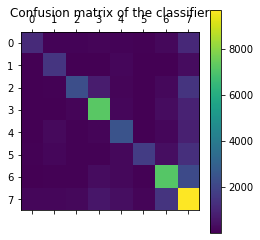

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(correct, predicted)

import pylab as pl
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

In [ ]:
Видно, что результат отличный от случайного угадывания наблюдается для всех классов (светлая диагональ). В исходных данных был дисбаланс классов (преобладал седьмой)